In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pyarrow as pa
from datetime import datetime, timedelta
from dateutil import rrule
import gcsfs
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
datasets = ["2023-05"]
bucket_name = "prediswiss-parquet-data"

In [4]:
fs_gcs = gcsfs.GCSFileSystem()
dataframes = []
for dataset in datasets:
    path = bucket_name + "/" + dataset + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    df = table.to_pandas()
    dataframes.append(df)
df = pd.concat(dataframes)

In [57]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = df[df['id'] == id].copy()

# Convert the 'publication_date' column to datetime
filtered_df[date] = pd.to_datetime(filtered_df[date])

# Convert the 'flow_11' column to numeric type
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')

# Set 'publication_date' as the index
filtered_df.set_index(date, inplace=True)

# Resample the data to the desired frequency (e.g., minute 'T' or second 'S') and calculate the mean
flow_11_data = filtered_df.resample('T').mean().fillna(0)

# Display the transformed data
display(flow_11_data)

# Split the data into training and testing sets
flow_11_data_train = flow_11_data.iloc[:24816]
flow_11_data_test = flow_11_data.iloc[24817:]

# Plot the time series data
plt.plot(flow_11_data.index, flow_11_data[target])
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{target} Time Series Data')
plt.xticks(rotation=90)
plt.legend([target], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

,publication_date,id,flow_1,flow_11,flow_21,speed_2,speed_12,speed_22
0,2023-05-23T04:56:18.156390Z,CH:0542.05,0,1320,0,None,118.599998,None
0,2023-05-23T04:55:18.078851Z,CH:0542.05,0,1380,60,None,118,116
0,2023-05-23T04:54:18.244448Z,CH:0542.05,0,1260,0,None,116.599998,None
0,2023-05-23T04:53:18.184744Z,CH:0542.05,0,1380,60,None,116.300003,104
0,2023-05-23T04:52:18.123365Z,CH:0542.05,0,1020,0,None,114,None
...,...,...,...,...,...,...,...,...
0,2023-05-29T01:01:18.199957Z,CH:0542.05,0,240,0,None,90.3000031,None
0,2023-05-29T01:00:18.140194Z,CH:0542.05,0,300,0,None,87.4000015,None
0,2023-05-29T00:59:18.098499Z,CH:0542.05,0,120,0,None,98.5,None
0,2023-05-29T00:58:18.039246Z,CH:0542.05,0,240,0,None,88,None


TypeError: Could not convert CH:0542.05 to numeric

In [60]:
import pmdarima as pm

model = pm.auto_arima(flow_11_data_train,start_p=1, d=1, start_q=1,
                            max_p=12, max_q=12,
                            m=12,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            stepwise=False,
                            suppress_warnings=True)
model.fit(flow_11_data_train)

pred = model.predict(n_periods=6204)

plt.plot(flow_11_data_test.index,pred, label='auto sarima')
plt.plot(flow_11_data_test, label='actual')
plt.title('Single-step Forecasting (automatic parameters)')
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

MemoryError: Unable to allocate 3.03 MiB for an array with shape (16, 24816) and data type float64

In [ ]:
sequenceOrder = []

for i in range(4):
    for j in range(4):
        for k in range(4):
            sequenceOrder.append((i, j, k))


for sequence in sequenceOrder:
    # Define the ARIMA model with the specified order (p, d, q)
    model = ARIMA(flow_11_data, order=sequence)

    # Fit the model to the data
    model_fit = model.fit()

    # Forecast future values
    forecast_values = model_fit.forecast(30000)

    print(forecast_values)

    # Plot the original data and the forecasted values
    plt.plot(flow_11_data, label='Original Data')
    plt.plot(forecast_values, label='Forecasted Data')
    plt.xlabel('Date')
    plt.ylabel('Flow 11')
    plt.title('Flow 11 Forecast for ' + " ".join(str(element) for element in sequence))
    # Adjust the legend orientation and position
    plt.legend(['Flow Actuel', 'Forecasted Flow'], loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate the x-axis tick labels for vertical orientation
    plt.xticks(rotation=90)

    # Adjust the figure size to extend the width
    plt.figure(figsize=(12, 6))
    plt.show()

In [100]:
train_size = int(len(publication_date) * 0.8)  # 80% for training, 20% for testing
train_data = publication_date[:train_size]
test_data = publication_date[train_size:]

The series is stationary


c:\Users\janis\miniconda3\envs\TB\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\janis\miniconda3\envs\TB\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\janis\miniconda3\envs\TB\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\janis\miniconda3\envs\TB\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

25255   -0.060954
25256   -0.036296
25257   -0.035209
25258   -0.035254
25259   -0.035354
           ...   
55250   -3.105514
55251   -3.105616
55252   -3.105718
55253   -3.105821
55254   -3.105923
Name: predicted_mean, Length: 30000, dtype: float64


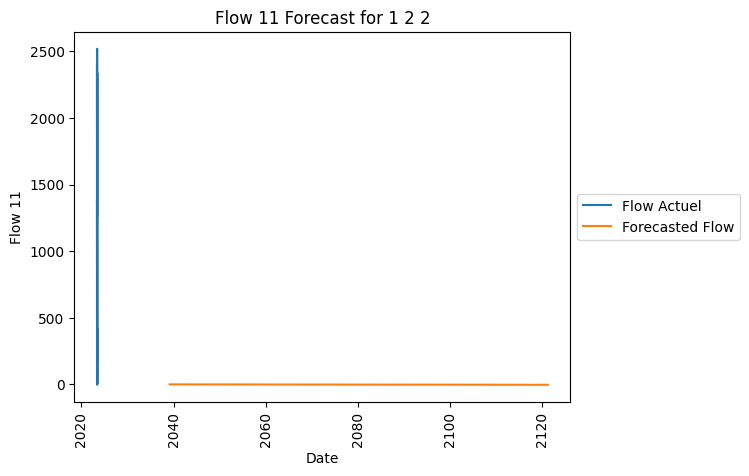

<Figure size 1200x600 with 0 Axes>

In [94]:
model = ARIMA(flow_11_data, order=(1, 2, 2))
# Fit the model to the data
model_fit = model.fit()

# Forecast future values
forecast_values = model_fit.forecast(30000)

print(forecast_values)

# Plot the original data and the forecasted values
plt.plot(flow_11_data, label='Original Data')
plt.plot(forecast_values, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Flow 11')
plt.title('Flow 11 Forecast for ' + " ".join(str(element) for element in (1,2,2)))
# Adjust the legend orientation and position
plt.legend(['Flow Actuel', 'Forecasted Flow'], loc='center left', bbox_to_anchor=(1, 0.5))

# Rotate the x-axis tick labels for vertical orientation
plt.xticks(rotation=90)

# Adjust the figure size to extend the width
plt.figure(figsize=(12, 6))
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(flow_11_data, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()